# Event severity



In [16]:
# builds the connection to azure:
%matplotlib inline

import os
import sys

import numpy as np
import panel as pn

import seaborn as sns

# import custom modules:
module_path = os.path.dirname(os.path.abspath(''))
if module_path not in sys.path:
    sys.path.append(module_path)
from common.get_data import *

#set colour palette for seaborn
colors = set_colours()
sns.set_palette(sns.color_palette(colors))
#get engine for sql queries
engine=get_engine()


server connected


In [2]:
# get model_version
model_version = pd.read_sql_query('''select value from model_metadata where item = 'model_version' ''', engine)
model_version = model_version.iloc[0][0]
model_version

'v2022.2.3'

## Get model data

In [3]:
# get model_data
df_model = pd.read_sql_query('''
    select
        model_events.run_id::text as entity,
        model_entities.revenue_band,
        model_events.confidentiality,
        model_events.targeted_event_type,
        gu_mean as event_impact,
        event_type as event_type,
        gu_bi_ratio * gu_mean as gu_bi,
        gu_contingent_bi_ratio * gu_mean as gu_cbi,
        gu_extortion_ratio * gu_mean as gu_extortion,
        gu_liability_ratio * gu_mean as gu_liability,
        gu_privacy_ratio * gu_mean as gu_privacy,
        gu_regulatory_ratio * gu_mean as gu_regulatory
    from
        model_events
    join
        model_entities
        on model_entities.run_id = model_events.run_id
''', engine)
#df_model.pop('entity')
df_model['source'] = 'model'


In [4]:
#aggregate event types to simplify
df_model['targeted_event_type'] = df_model['targeted_event_type'].fillna('systemic')
df_model['targeted_event_type'] = df_model['targeted_event_type'].replace('service_provider_data_breach', 'data_breach')
df_model['targeted_event_type'] = df_model['targeted_event_type'].replace('service_provider_interruption', 'interruption')
df_model['targeted_event_type'].unique()

array(['interruption', 'systemic', 'data_breach', 'ransomware'],
      dtype=object)

## Get Events data

In [5]:
df_events = read_f1k_table()
df_events.rename({'total_cost_usd':'event_impact',
                 }, axis='columns', inplace=True)


df_events['event_impact']=df_events['total_cost_millions_usd']*1e6

df_events['source']='events'

server connected


# Compare overall severity


Text(19400000.0, 0.35, 'IBM Mean')

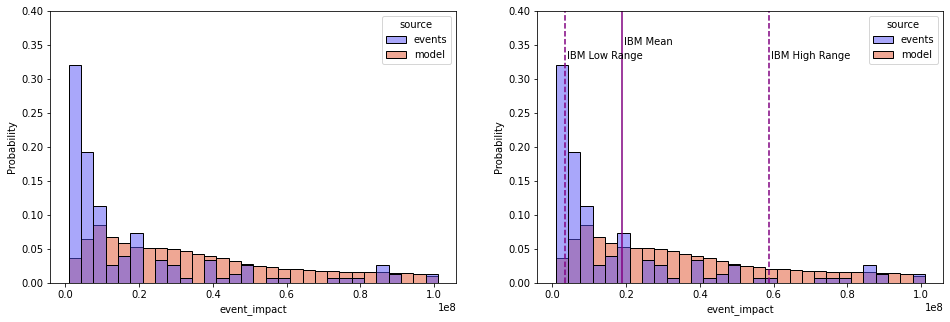

In [6]:
fig, ax = plt.subplots(1,2, figsize=(16,5))

minimum = 1_000_000
limit = 100_000_000
bins=30

common_cols = ['event_impact','source']
plot_data = pd.concat([
  df_events.loc[df_events['impact_type_confidentiality']==True][common_cols], 
  df_model.loc[df_model['confidentiality']==1][common_cols]
  ], sort=False).reset_index()

plot_data = plot_data.loc[
  (plot_data['event_impact']<=limit) &
  (plot_data['event_impact']>minimum)
  ]

sns.histplot(
  data=plot_data.loc[plot_data['event_impact']<=limit],
  x='event_impact', 
  hue='source', 
  stat='probability',
  binwidth=limit/bins, 
  alpha=0.5,
  common_norm=False,ax=ax[0])

sns.histplot(
  data=plot_data.loc[plot_data['event_impact']<=limit],
  x='event_impact', 
  hue='source', 
  stat='probability',
  binwidth=limit/bins, 
  alpha=0.5,
  common_norm=False,ax=ax[1])


ax[0].set_ylim(0, 0.4)
ax[1].set_ylim(0, 0.4)

# IBM Cost of data breach report 2021
ax[1].axvline(3.6e6, color='purple', ls='--')
ax[1].text(3.6e6+5e5,0.33, 'IBM Low Range')
ax[1].axvline(58.8e6, color='purple', ls='--')
ax[1].text(58.8e6+5e5,0.33, 'IBM High Range')
ax[1].axvline(18.9e6, color='purple', ls='-')
ax[1].text(18.9e6+5e5,0.35, 'IBM Mean')


# Split Cost Components

In [7]:
# Event cost mapping
df_events_TP = df_events.copy()
df_events_TP['gu_liability'] = (
    df_events_TP['liability_third_party_cost_millions_usd'] * 1e6 
    +df_events_TP['injury_cost_millions_usd'] * 1e6
    +df_events_TP['settlement_amount_paid_millions_usd'] * 1e6
    +df_events_TP['liability_first_party_cost_millions_usd'] * 1e6)

df_events_TP['gu_bi'] = (
    df_events_TP['lost_income_cost_millions_usd'] * 1e6
    +df_events_TP['property_cost_millions_usd'] * 1e6
    )
df_events_TP['gu_privacy'] = (
    df_events_TP['other_costs_millions_usd'] * 1e6
    +df_events_TP['response_cost_millions_usd'] * 1e6
)
df_events_TP['gu_regulatory'] = df_events_TP['regulatory_costs_millions_usd'] * 1e6
df_events_TP['gu_extortion'] = df_events_TP['extortion_paid_millions_usd'] * 1e6

# Model cost Mapping
df_model_TP = df_model.copy()
df_model_TP['gu_bi'] = df_model_TP['gu_bi'] + df_model_TP['gu_cbi']

#join tables
df_costs = pd.concat([
    df_model_TP[['gu_liability','gu_regulatory', 'gu_bi', 'gu_extortion', 'gu_privacy', 'source']].reset_index(),
    df_events_TP[['gu_liability','gu_regulatory', 'gu_bi', 'gu_extortion', 'gu_privacy', 'source']].reset_index()
],sort=False).reset_index()


Text(0.5, 1.0, 'liability costs')

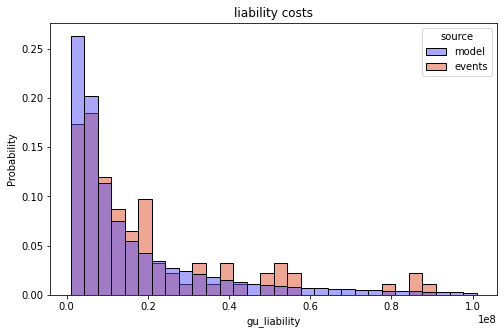

In [8]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

minimum = 1_000_000
limit = 100_000_000
bins=30

param = 'gu_liability'
plot_data = df_costs
plot_data = plot_data.loc[(plot_data[param]<=limit) &
              (plot_data[param]>minimum)
                ]

sns.histplot(
  data=plot_data.loc[plot_data[param]<=limit],
  x=param,
  hue='source',
  stat='probability',
  binwidth=limit/bins,
  alpha=0.5,
  common_norm=False, 
  ax=ax
  )
ax.set_title('liability costs')

Text(0.5, 1.0, 'regulatory costs')

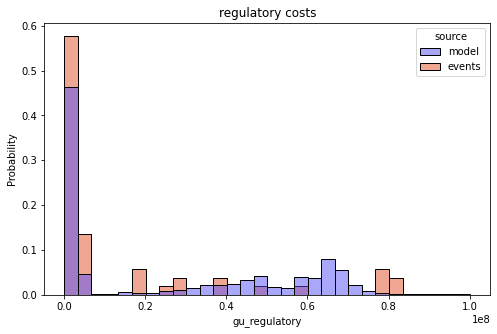

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

minimum = 100_000
limit = 100_000_000
bins=30

param = 'gu_regulatory'
plot_data = df_costs
plot_data = plot_data.loc[(plot_data[param]<=limit) &
              (plot_data[param]>minimum)
                ]

sns.histplot(
  data=plot_data.loc[plot_data[param]<=limit],
  x=param,
  hue='source',
  stat='probability',
  binwidth=limit/bins,
  alpha=0.5,
  common_norm=False, 
  ax=ax,
  )
ax.set_title('regulatory costs')

Text(0.5, 1.0, 'privacy costs')

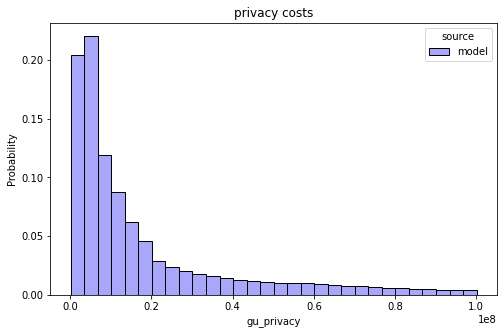

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

minimum = 100_000
limit = 100_000_000
bins=30

param = 'gu_privacy'
plot_data = df_costs
plot_data = plot_data.loc[(plot_data[param]<=limit) &
              (plot_data[param]>minimum)
                ]

sns.histplot(
  data=plot_data.loc[plot_data[param]<=limit],
  x=param,
  hue='source',
  stat='probability',
  binwidth=limit/bins,
  alpha=0.5,
  common_norm=False, 
  ax=ax,
  )
ax.set_title('privacy costs')

Text(0.5, 1.0, 'business interruption costs')

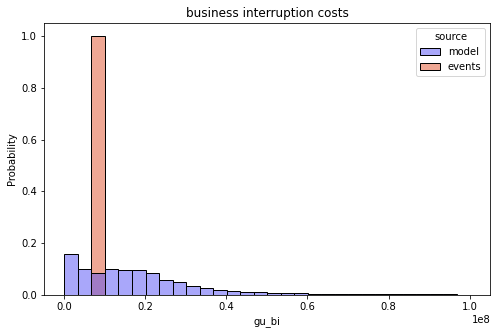

In [11]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

minimum = 100_000
limit = 100_000_000
bins=30

param = 'gu_bi'
plot_data = df_costs
plot_data = plot_data.loc[(plot_data[param]<=limit) &
              (plot_data[param]>minimum)
                ]

sns.histplot(
  data=plot_data.loc[plot_data[param]<=limit],
  x=param,
  hue='source',
  stat='probability',
  binwidth=limit/bins,
  alpha=0.5,
  common_norm=False, 
  ax=ax,
  )
ax.set_title('business interruption costs')

Text(0.5, 1.0, 'extortion costs')

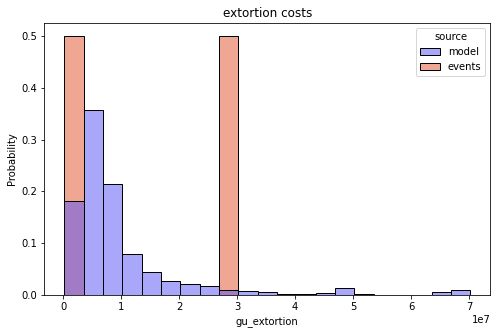

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

minimum = 100_000
limit = 100_000_000
bins=30

param = 'gu_extortion'
plot_data = df_costs
plot_data = plot_data.loc[(plot_data[param]<=limit) &
              (plot_data[param]>minimum)
                ]

sns.histplot(
  data=plot_data.loc[plot_data[param]<=limit],
  x=param,
  hue='source',
  stat='probability',
  binwidth=limit/bins,
  alpha=0.5,
  common_norm=False, 
  ax=ax,
  )
ax.set_title('extortion costs')

## Model Cost Split

In [13]:
df_model_cost = df_model.reset_index()[['index',
                         'gu_bi',
                         'gu_cbi',
                         'gu_extortion',
                         'gu_liability',
                         'gu_privacy',
                         'gu_regulatory',
                         'event_impact'
                         ]].copy()

In [14]:
df_model_cost = df_model_cost.melt(id_vars='index', var_name='cost_component',value_name='value')

<AxesSubplot:xlabel='value', ylabel='Probability'>

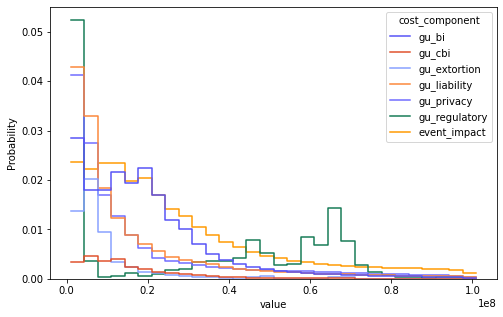

In [15]:
fig, ax = plt.subplots(1,1, figsize=(8,5))

minimum = 1_000_000
limit = 100_000_000
bins=30

plot_data = df_model_cost
plot_data = plot_data.loc[(plot_data['value']<=limit) &
              (plot_data['value']>minimum)
                ]

sns.histplot(
  data=plot_data,
  x='value',
  hue='cost_component',
  stat='probability',
  binwidth=limit/bins,
  alpha=1,
  common_norm=True, 
  #multiple='layer',
  #kde=True,
  element='step',
  fill=False,
  )